# CSE416 - Final Project: Link Prediction

name: Angelica Tao Zhu, Yue Lin

In [1]:
import networkx as nx
import numpy as np

# load General Relativity and Quantum Cosmology collaboration network from text file
collaboration_network = nx.Graph()
with open("dataset/ca-GrQc.txt", "r") as fp:
    line = fp.readline()
    # skip comments
    while line[0] == '#':
        line = fp.readline()
        
    while line:
        edge = line.split()
        collaboration_network.add_edge(edge[0], edge[1])
        line = fp.readline()

# load facebook ego network
facebook_ego = nx.Graph()
with open("dataset/facebook_combined.txt", "r") as fp:
    line = fp.readline()
        
    while line:
        edge = line.split()
        facebook_ego.add_edge(edge[0], edge[1])
        line = fp.readline()
        
# load email-Eu-core temporal network
email_eu = nx.Graph()
with open("dataset/email-Eu-core-temporal.txt", "r") as fp:
    line = fp.readline()
    while line:
        edge = line.split()
        email_eu.add_edge(edge[0], edge[1])
        line = fp.readline()

In [2]:
def loadGraph(fileName):
    g = nx.Graph()
    with open("dataset/" + fileName + ".txt", "r") as fp:
        line = fp.readline()
        
        # skip comments
        while line[0] == '#':
            line = fp.readline()
            
        while line:
            edge = line.split()
            g.add_edge(edge[0], edge[1])
            line = fp.readline()
    return g

In [3]:
def splitFile(fileName, percentage):
    filePath = 'dataset/' + fileName + '.txt'
    num_lines = sum(1 for line in open(filePath))
    num_train_lines = int(num_lines * percentage)
    with open(filePath) as fp:
        count = 1
        line = fp.readline()
        
        trainf = open('dataset/' + fileName + '_train.txt', "a")
        while count < num_train_lines:
            trainf.write(line)
            line = fp.readline()
            count += 1
        
        testf = open('dataset/' + fileName + '_test.txt', "a")
        while line:
            testf.write(line)
            line = fp.readline()

In [4]:
def _apply_prediction(G, func, ebunch=None):
    """Applies the given function to each edge in the specified iterable
    of edges.

    `G` is an instance of :class:`networkx.Graph`.

    `func` is a function on two inputs, each of which is a node in the
    graph. The function can return anything, but it should return a
    value representing a prediction of the likelihood of a "link"
    joining the two nodes.

    `ebunch` is an iterable of pairs of nodes. If not specified, all
    non-edges in the graph `G` will be used.

    """
    if ebunch is None:
        ebunch = nx.non_edges(G)
    return ((u, v, func(u, v)) for u, v in ebunch)

In [5]:
def jaccard_coefficient(G, ebunch=None):
    """Compute the Jaccard coefficient of all node pairs in ebunch.

    Jaccard coefficient of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.

    Examples
    --------
    >>> import networkx as nx
    >>> G = nx.complete_graph(5)
    >>> preds = nx.jaccard_coefficient(G, [(0, 1), (2, 3)])
    >>> for u, v, p in preds:
    ...     '(%d, %d) -> %.8f' % (u, v, p)
    ...
    '(0, 1) -> 0.60000000'
    '(2, 3) -> 0.60000000'

    References
    ----------
    .. [1] D. Liben-Nowell, J. Kleinberg.
           The Link Prediction Problem for Social Networks (2004).
           http://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    """
    def predict(u, v):
        union_size = len(set(G[u]) | set(G[v]))
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(G, u, v))) / union_size
    return _apply_prediction(G, predict, ebunch)

In [6]:
def sorensen_index(G, ebunch=None):
    """Compute the Sorensen Index of all node pairs in ebunch.

    Sorensen Index of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u)| + |\Gamma(v)|}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        union_size = len(set(G[u])) + len(set(G[v]))
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(G, u, v))) / union_size
    return _apply_prediction(G, predict, ebunch)

In [7]:
def salton_cosine_similarity(G, ebunch=None):
    """Compute the Salton Cosine Similarity of all node pairs in ebunch.

    Salton Cosine Similarity of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{\sqrt{|\Gamma(u)| \times |\Gamma(v)|}}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        import math
        union_size = math.sqrt(len(set(G[u])) * len(set(G[v])))
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(G, u, v))) / union_size
    return _apply_prediction(G, predict, ebunch)

In [8]:
def preferential_attachment(G, ebunch=None):
    """Compute the Preferential Attachment of all node pairs in ebunch.

    Preferential Attachment of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{\sqrt{|\Gamma(u)| \times |\Gamma(v)|}}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        return len(set(G[u])) * len(set(G[v]))
    return _apply_prediction(G, predict, ebunch)

In [75]:
def rank(pred):
    """
    Parameters
    ----------
    pred : An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.

    k : keep top k element based p

    Returns
    -------
    top k list
    """
    l = [(u, v, p) for u, v, p in pred]
    
    sorted_l = sorted(l, key=lambda x: x[2], reverse=True)
    return sorted_l

In [10]:
splitFile('email-Eu-core-temporal', 0.9)
email_train_g = loadGraph('email-Eu-core-temporal_train')

In [11]:
pred = salton_cosine_similarity(email_train_g)
# print(res)

In [12]:
# evaluating prediction quality

def prediction_eval(G, true_links, pred_links):
    """
    G: network before prediction
    """
    true_links = set(true_links)
    pred_links = set(pred_links)
    TP = 0; TN = 0; FP = 0; FN = 0

    for u, v in nx.non_edges(G):
        in_true_links = ((u,v) in true_links or (v,u) in true_links)
        in_pred_links = ((u,v) in pred_links or (v,u) in pred_links)
        
        if in_true_links and in_pred_links:
            TP += 1
        elif not in_true_links and in_pred_links:
            FP += 1
        elif in_pred_links and not in_pred_links:
            FN += 1
        else:
            TN += 1
    
#     print (TP, FP, FN, TN)
#     precision = TP / (TP + FP)
    return TP, FP, FN, TN

In [13]:
# load true links
def load_true_links(filename):
    # load true links
    true_links = []
    with open(filename, "r") as fp:
        line = fp.readline()

        # skip comments
        while line[0] == '#':
            line = fp.readline()

        while line:
            edge = line.split()
            true_links.append((edge[0], edge[1]))
            line = fp.readline()
    
    return true_links

In [14]:
def katz_based_metric(G, cutoff=3, beta=0.8, ebunch=None):
    """Compute the Katz based metric of all node pairs in ebunch.

    Katz based metric of nodes `u` and `v` is defined as

    .. math::

        Katz(x, y) = βA + β2A2 + β3A3 + ...

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        curB = 1
        katz = 0
        c = compute_num_of_path(email_train_g, u, v, cutoff)
        for i in range(1, cutoff + 1):
            curB *= beta
            katz += curB * c[i]
        return katz
    return _apply_prediction(G, predict, ebunch)

In [15]:
def local_path_based_metric(G, alpha=0.8, ebunch=None):
    """Compute the Local Path based metric of all node pairs in ebunch.

    Local Path based metric of nodes `u` and `v` is defined as

    .. math::

        lp(x, y) = A2 + alpha*A3...

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        c = compute_num_of_path(email_train_g, u, v, 3)
        return c[2] + alpha * c[3]
    return _apply_prediction(G, predict, ebunch)

In [61]:
def commute_time_based_metric(G, ebunch=None):
    """Compute the commute time based metric of all node pairs in ebunch.

    commute time based metric of nodes `u` and `v` is defined as

    .. math::

        CT(x, y) = HT(x, y) + HT(y, x) = m(L†x,x + L†y,y − 2L†x,y),

    where L† is the pseudo-inverse of matrix L = DA − A and m is number of edges in a social network.

    """
    import networkx as nx, numpy as np
    nodelist = sorted(G.nodes)
    L = nx.laplacian_matrix(G, nodelist=nodelist).toarray()
    CTK = np.linalg.pinv(L) # L†
    m = len(G.edges())
    def predict(u, v):
        ind_u = nodelist.index(u)
        ind_v = nodelist.index(v)
        return 1/((CTK[ind_u][ind_u] + CTK[ind_v][ind_v] - 2*CTK[ind_v][ind_u]))
    return _apply_prediction(G, predict, ebunch)

In [ ]:
def personalized_pagerank(G, ebunch=None):
    """Compute the page rank based metric of all node pairs in ebunch.

    personalized(rooted) page rank based metric of nodes `u` and `v` is defined as

    .. math::

        RPR = (1 − )(I − D−1A)−1.

   where D is the diagonal matrix  with Di,i = Sum(j Ai,j).

    """
    def predict(u, v):
        return nx.pagerank(G,personalization={u : v})
    return _apply_prediction(G, predict, ebunch)

In [62]:
pred = commute_time_based_metric(email_train_g)
res = rank(pred, 2000)

In [16]:
import collections
def compute_num_of_path(G, u, v, cutoff):
    paths = nx.all_simple_paths(G, source=u, target=v, cutoff=cutoff)
    paths_len = [len(path) - 1 for path in paths]
    return collections.Counter(paths_len)

In [30]:
pred = local_path_based_metric(email_train_g)

In [19]:
c = compute_num_of_path(email_train_g, '587', '245', 3)
cutoff = 3
beta = 0.8
curB = 1
katz = 0
for i in range(1, cutoff + 1):
    curB *= beta
    katz += curB * c[i]
print(katz)

380.1920000000001


In [39]:
# TP, FP, FN, TN

pred = preferential_attachment(email_train_g)
res = rank(pred, 2000)

pred_pairs = [(u,v) for u,v,p in res]
true_links = load_true_links("dataset/email-Eu-core-temporal_test.txt")
TP, FP, FN, TN = prediction_eval(email_train_g, true_links, pred_pairs)
precision = TP / (TP + FP)
print(precision)

0.067


In [17]:
def iter_to_list(it):
    l = []
    for u, v, p in it:
        l.append((u,v,p))
    return l

In [77]:
import numpy as np

x = []
precisions = []
TPs = []
FPs = []
FNs = []
TNs = []

pred = commute_time_based_metric(email_train_g)
pred = iter_to_list(pred)
true_links = load_true_links("dataset/email-Eu-core-temporal_test.txt")
pred = rank(pred)

for i in np.arange(5,len(pred),100):
    res = pred[0: i]
#     print(res)
    pred_pairs = [(u,v) for u,v,p in res]
    TP, FP, FN, TN = prediction_eval(email_train_g, true_links, pred_pairs)
    x.append(i)
    TPs.append(TP)
    FPs.append(FP)
    TNs.append(TN)
    FNs.append(FN)
    precision = TP / (TP + FP)
    precisions.append(precision)
    print(i)

5
105
205
305
405
505
605
705
805
905
1005
1105
1205
1305
1405
1505
1605
1705
1805
1905
2005
2105
2205
2305
2405
2505
2605
2705
2805
2905
3005
3105
3205
3305
3405
3505
3605
3705
3805
3905
4005
4105
4205
4305
4405
4505
4605
4705
4805
4905
5005
5105
5205
5305
5405
5505
5605
5705
5805
5905
6005
6105
6205
6305
6405
6505
6605
6705
6805
6905
7005
7105
7205
7305
7405
7505
7605
7705
7805
7905
8005
8105
8205
8305
8405
8505
8605
8705
8805
8905
9005
9105
9205
9305
9405
9505
9605
9705
9805
9905
10005
10105
10205
10305
10405
10505
10605
10705
10805
10905
11005
11105
11205
11305
11405
11505
11605
11705
11805
11905
12005
12105
12205
12305
12405
12505
12605
12705
12805
12905
13005
13105
13205
13305
13405
13505
13605
13705
13805
13905
14005
14105
14205
14305
14405
14505
14605
14705
14805
14905
15005
15105
15205
15305
15405
15505
15605
15705
15805
15905
16005
16105
16205
16305
16405
16505
16605
16705
16805
16905
17005
17105
17205
17305
17405
17505
17605
17705
17805
17905
18005
18105
18205
18305
18405
18

133005
133105
133205
133305
133405
133505
133605
133705
133805
133905
134005
134105
134205
134305
134405
134505
134605
134705
134805
134905
135005
135105
135205
135305
135405
135505
135605
135705
135805
135905
136005
136105
136205
136305
136405
136505
136605
136705
136805
136905
137005
137105
137205
137305
137405
137505
137605
137705
137805
137905
138005
138105
138205
138305
138405
138505
138605
138705
138805
138905
139005
139105
139205
139305
139405
139505
139605
139705
139805
139905
140005
140105
140205
140305
140405
140505
140605
140705
140805
140905
141005
141105
141205
141305
141405
141505
141605
141705
141805
141905
142005
142105
142205
142305
142405
142505
142605
142705
142805
142905
143005
143105
143205
143305
143405
143505
143605
143705
143805
143905
144005
144105
144205
144305
144405
144505
144605
144705
144805
144905
145005
145105
145205
145305
145405
145505
145605
145705
145805
145905
146005
146105
146205
146305
146405
146505
146605
146705
146805
146905
147005
147105
147205

250105
250205
250305
250405
250505
250605
250705
250805
250905
251005
251105
251205
251305
251405
251505
251605
251705
251805
251905
252005
252105
252205
252305
252405
252505
252605
252705
252805
252905
253005
253105
253205
253305
253405
253505
253605
253705
253805
253905
254005
254105
254205
254305
254405
254505
254605
254705
254805
254905
255005
255105
255205
255305
255405
255505
255605
255705
255805
255905
256005
256105
256205
256305
256405
256505
256605
256705
256805
256905
257005
257105
257205
257305
257405
257505
257605
257705
257805
257905
258005
258105
258205
258305
258405
258505
258605
258705
258805
258905
259005
259105
259205
259305
259405
259505
259605
259705
259805
259905
260005
260105
260205
260305
260405
260505
260605
260705
260805
260905
261005
261105
261205
261305
261405
261505
261605
261705
261805
261905
262005
262105
262205
262305
262405
262505
262605
262705
262805
262905
263005
263105
263205
263305
263405
263505
263605
263705
263805
263905
264005
264105
264205
264305

367205
367305
367405
367505
367605
367705
367805
367905
368005
368105
368205
368305
368405
368505
368605
368705
368805
368905
369005
369105
369205
369305
369405
369505
369605
369705
369805
369905
370005
370105
370205
370305
370405
370505
370605
370705
370805
370905
371005
371105
371205
371305
371405
371505
371605
371705
371805
371905
372005
372105
372205
372305
372405
372505
372605
372705
372805
372905
373005
373105
373205
373305
373405
373505
373605
373705
373805
373905
374005
374105
374205
374305
374405
374505
374605
374705
374805
374905
375005
375105
375205
375305
375405
375505
375605
375705
375805
375905
376005
376105
376205
376305
376405
376505
376605
376705
376805
376905
377005
377105
377205
377305
377405
377505
377605
377705
377805
377905
378005
378105
378205
378305
378405
378505
378605
378705
378805
378905
379005
379105
379205
379305
379405
379505
379605
379705
379805
379905
380005
380105
380205
380305
380405
380505
380605
380705
380805
380905
381005
381105
381205
381305
381405

In [73]:
len(pred)

459640

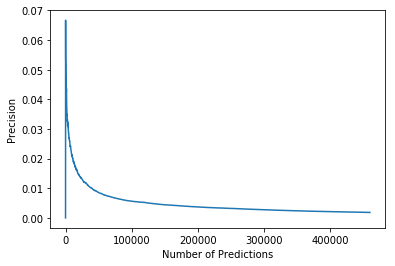

In [78]:
import matplotlib.pyplot as plt

# plot graph
plt.plot(x, precisions,'-')
plt.xlabel('Number of Predictions')
plt.ylabel('Precision')
# save graph to local file
# plt.savefig("degree_distribution.png", dpi=400) # save as png
plt.show()

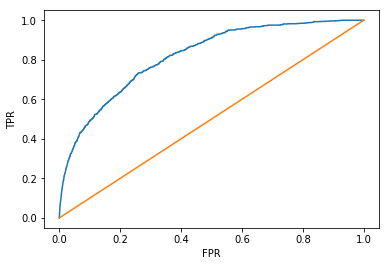

In [81]:
import matplotlib.pyplot as plt
#ROC
FPRs = [FPs[i] / (FPs[i] + TNs[i]) for i in range(len(FPs))]
TPRs = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(TPs))]
plt.plot(FPRs, TPRs,'-')
plt.xlabel('FPR')
plt.ylabel('TPR')
# save graph to local file
# plt.savefig("degree_distribution.png", dpi=400) # save as png
x = np.arange(0,1.1,0.1)
plt.plot(x, x,'-')
plt.show()

In [17]:
preds = nx.jaccard_coefficient(email_train_g)
count = 0
l = []
for u, v, p in preds:
    if p > 0:
        l.append((u, v, p))
#     print('(%s, %s) -> %.8f' % (u, v, p))

KeyboardInterrupt: 

In [57]:
G = nx.complete_graph(5)
preds = nx.jaccard_coefficient(G)
for u, v, p in preds:
    print('(%d, %d) -> %.8f' % (u, v, p))